# 07 Solution: Sine Series

* *Computational Physics*:  2.5


## Problem: Summing Series: sin(x)

Evaluate the $\sin$ function from its series representation
$$
\sin x = x - \frac{x^3}{3!} + \frac{x^5}{5!} - \frac{x^7}{7!} + \dots
$$

A naive algorithm is to sum the series up to the $N$th term:
$$
\sin x \approx \sum_{n=1}^N \frac{(-1)^{n-1} x^{2n-1}}{(2n - 1)!}
$$

Problems:

- How to decide when to stop summing?
- Division of large terms (overflows!)
- Powers and factorials are very expensive to compute.

Better approach: Build up series terms $a_n$ using previous term $a_{n-1}$ through a recursion:

\begin{align}
a_n &= a_{n-1} \times q_n\\
a_n &= \frac{(-1)^{n-1} x^{2n-1}}{(2n - 1)!} = \frac{(-1)^{n-2} x^{2n-3}}{(2n - 3)!} \frac{-x^2}{(2n - 1)(2n - 2)}\\
a_n & = a_{n-1} \frac{-x^2}{(2n - 1)(2n - 2)}
\end{align}

Accuracy of this approach? Not clear in absolute terms but we can make the assumption that the error is approximately the last term in the sum, $a_N$. Hence we can strive to make the relative error smaller than the machine precision
$$
\left| \frac{a_N}{\sum_{n=1}^N a_n} \right| < \epsilon_m
$$



In [7]:
import numpy as np

In [8]:
def sin_series(x, eps=1e-16):
    """Calculate sin(x) to precision eps with recursion.
        
    Arguments
    ---------
    x : float
        argument of sin(x)
    eps : float, optional
        desired precision
        
    Returns
    -------
    func_value, N
    
    where func_value = sin(x) and N is the number
    of terms included in the approximation.
    """
    if x == 0:
        return 0., 1
    a_n = sumN = x   # a_1 is the sum
    n = 2            # start with calculating a_2
    while abs(a_n/sumN) > eps:
        a_n *= -x*x/((2*n - 1)*(2*n - 2)) 
        sumN += a_n
        n += 1
    return sumN, n-1

Bonus problem: the really bad implementation:

In [9]:
import math
def sin_series_bad(x, eps=1e-16):
    """Calculate sin(x) to precision eps... BADLY"""
    if x == 0:
        return 0., 1
    a_n = x
    n = 1
    sumN = 0.
    while True:
        a_n = (-1)**(n-1) * x**(2*n-1) / math.factorial(2*n-1)
        sumN += a_n
        if abs(a_n/sumN) <=  eps:
            break
        n += 1
    return sumN, n

In [10]:
sin_series_bad(14*np.pi)

(253.21339842367362, 73)

In [11]:
sin_series(100*np.pi, eps=1e-16)

(6.591899418779782e+118, 277)

Test the implementation against the "exact" numpy function `np.sin()`.

Report
1. `x`
2. maximum `n`
3. `sin_series(x)`
4. relative error `abs(sin_series(x) - sin(x))/abs(sin(x))`

Plot against `x` the quantities above and also `sin(x)`.
* `x` - `sin_series(x)`
* `x` - `sin(x)`
* `x` - max `n`
* `x` - relative error (semilogy plot!)

For a range of numbers look at `Xsmall` and `Xlarge`:

In [12]:
Xsmall = np.pi*np.arange(-2, 2.05, 0.05)
Xlarge = np.pi*np.arange(-50, 50.05, 0.1)

Implementation (modularized compared to the problem so that I can use it for `sin_series()` and `sin_series_bad()`):

In [15]:
import numpy as np
def test_sin(x):
    y, nmax = sin_series(x)
    return compare_to_sin(x, y, nmax)

def test_sin_bad(x):
    y, nmax = sin_series_bad(x)
    return compare_to_sin(x, y, nmax)


def compare_to_sin(x, y, nmax):
    y0 = np.sin(x)
    delta = y - y0
    if y0 != 0:
        relative_error = delta/y0
    else:
        relative_error = 0
    # print(x, y, y0, delta, relative_error)
    #return x, y, y0, delta, relative_error
    return x, nmax, y, relative_error, delta

The functions do not work as numpy ufuncs on whole arrays; therefore, loop over all input values $x$ like the following code:

In [16]:
results = np.array([test_sin(x) for x in Xsmall])

Plot the approximation and the exact solution:

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
def test_plot_sine(X, filename="sine_error.pdf"):
    results = np.array([test_sin(x) for x in X])
    return plot_results(results, filename)
   
def test_plot_bad_sine(X, filename="sine_bad_error.pdf"):
    results = np.array([test_sin_bad(x) for x in X])
    return plot_results(results, filename)    

def plot_results(results, filename):
    fig = plt.figure(figsize=(6, 8))
    
    ax1 = fig.add_subplot(4,1,1)
    ax1.plot(results[:, 0], results[:, 2], 'k-', lw=1, label="series")
    ax1.plot(results[:, 0], np.sin(results[:, 0]), 'g--', lw=2, label="sin x")
    ax1.legend(loc="best")

    ax2 = fig.add_subplot(4,1,2)
    ax2.plot(results[:, 0], results[:, 1], label="max n")
    ax2.legend(loc="best")

    ax3 = fig.add_subplot(4,1,3)
    ax3.semilogy(results[:, 0], results[:, 3], label="rel.error")
    ax3.legend(loc="best")
    
    ax4 = fig.add_subplot(4, 1, 4)
    ax4.semilogy(results[:, 0], results[:, 4], label="abs.error")
    ax4.legend(loc="best")

    fig.suptitle("sine series approximation")
    
    fig.savefig(filename)
    print("saved to file {0}".format(filename))

Now test the two ranges of numbers and write to different files:

For a few oscillations near $x=0$ the approximation appears to hold pretty well with relative errors near machine precision.

saved to file sine_error_Xsmall.pdf


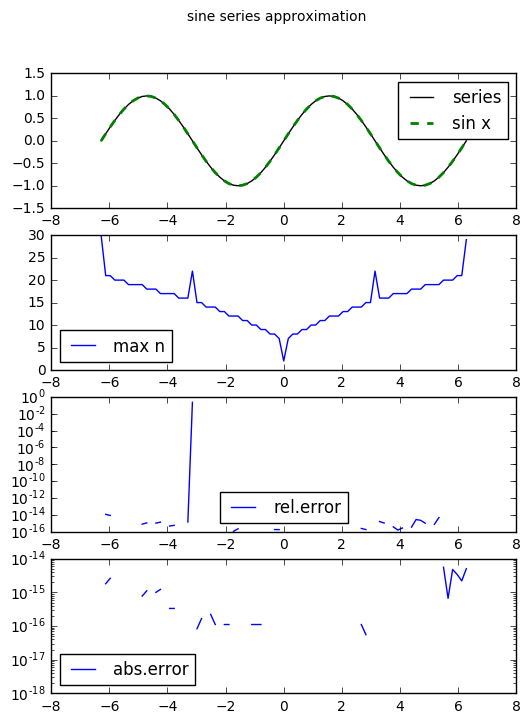

In [29]:
test_plot_sine(Xsmall, filename="sine_error_Xsmall.pdf")

But for larger $|x|$, the approximation breaks down and round-off error completely swamps the result:

saved to file sine_error_Xlarge.pdf


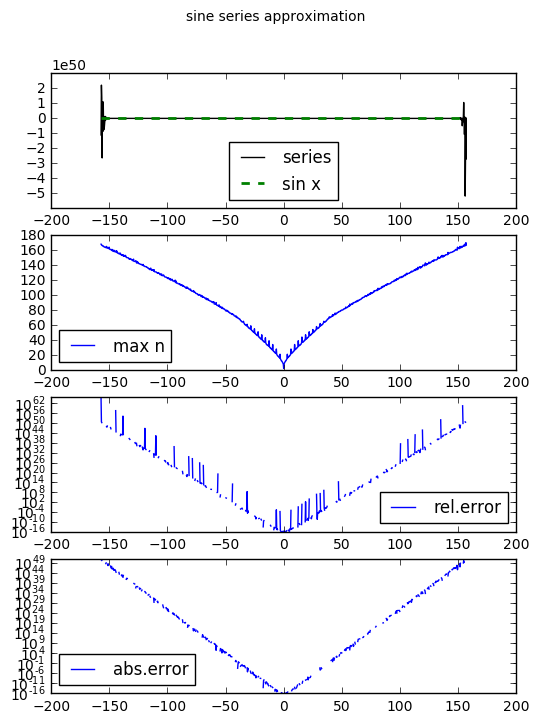

In [30]:
test_plot_sine(Xlarge, filename="sine_error_Xlarge.pdf")

#### More exploration 

saved to file sine_error.pdf


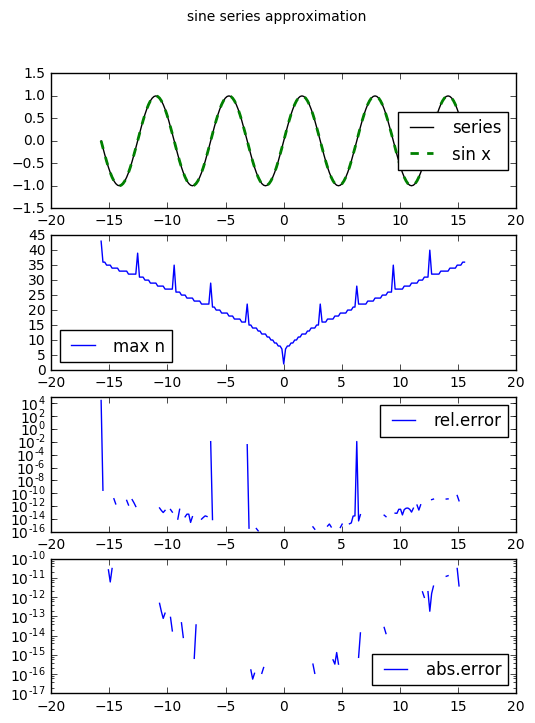

In [31]:
test_plot_sine(np.pi*np.arange(-5, 5, 0.05))

saved to file sine_error.pdf


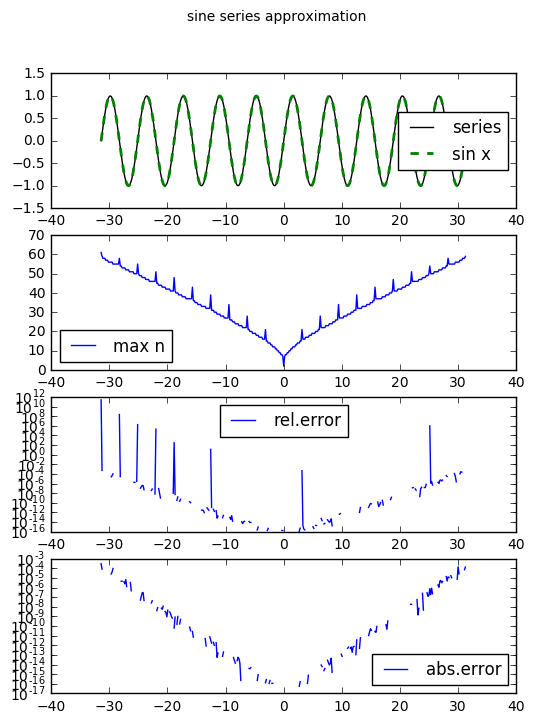

In [32]:
test_plot_sine(np.pi*np.arange(-10, 10, 0.05))

saved to file sine_error.pdf


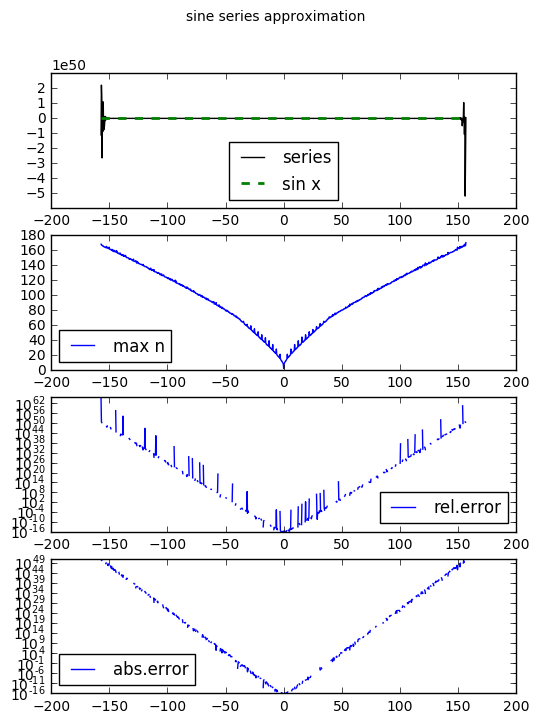

In [34]:
test_plot_sine(np.pi*np.arange(-50, 50, 0.1))